## TESINA Matematica per l'Intelligenza Artificiale
### Edoardo Vay


Analisi del dataset Faces in the Wild con PCA e MLP

In [14]:
# STILE DI VISUALIZZAZIONE PLOT FATTI CON MATPLOTLIB
#%matplotlib widget
#
import pandas as pd
import numpy as np
from sklearn import datasets
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, make_scorer
from IPython.display import display
from collections import Counter
from imblearn.over_sampling import RandomOverSampler 

Per cominciare scarico il dataset in modo che includa le persone che compaiono almeno un numero di volte specificato; in questo modo posso evitare di studiare il dataset con troppe classi troppo poco rappresentate.

In [15]:
lfw_people = datasets.fetch_lfw_people(min_faces_per_person=100, resize=0.45)

face_data = lfw_people['data']
face_images = lfw_people['images']
face_tnames = lfw_people['target_names']
face_targets = lfw_people['target']

## Composizione del Dataset
Analizzando la distribuzione dei campione nelle classi noto che non è molto bilanciata: l'immagine di Bush infatti ricorre molto più spesso delle altre.
In seguito infatti utilizzero la tecnica dell'Oversampling per provare a eliminare il problema dell'overfitting.

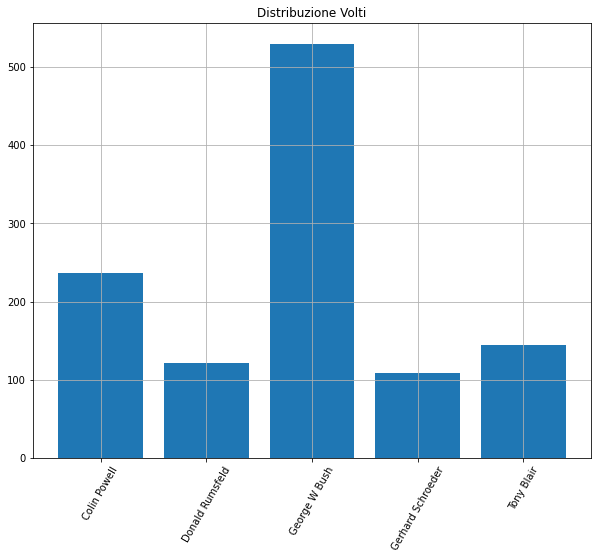

In [16]:
face_df = pd.DataFrame(face_targets)
face_df['target_names'] = [face_tnames[t] for t in face_df[0]]
plt.figure(figsize=(10, 8))
plt.title('Distribuzione Volti')
plt.bar(np.arange(len(face_tnames)), face_df[0].value_counts(sort = False))
plt.xticks(np.arange(len(face_tnames)), labels = face_tnames, rotation = 60)
plt.grid()
plt.show()

#### Suddivido i dati in due porzioni per addestrare e testare il MLP
il 40% dei dati verrà usato solo il fase di Testing, mentre il resto del dataset sarà usato per l'addestramento della rete neurale.

In [17]:
random_state = 20212207
test_p = 0.4
val_p = 0.25  # Percentuale di dati di X_trainval da usare come validation set

X_trainval, X_test, y_trainval, y_test = train_test_split(face_data, face_targets, test_size=test_p, random_state=random_state, shuffle=True)

display(pd.DataFrame({'X_trainval': X_trainval.shape, 'X_test': X_test.shape}, index=['N. sanmples', 'N.features']))

,X_trainval,X_test
N. sanmples,684,456
N.features,2352,2352


#### Ora analizzo la Distribuzione delle classi nelle parti di test e di training e noto che il metodo mantiene la distribuzione delle classi invariata nelle due porzioni in cui a diviso il dataset apposta per evitare di introdurre sbilanciamenti nel training.


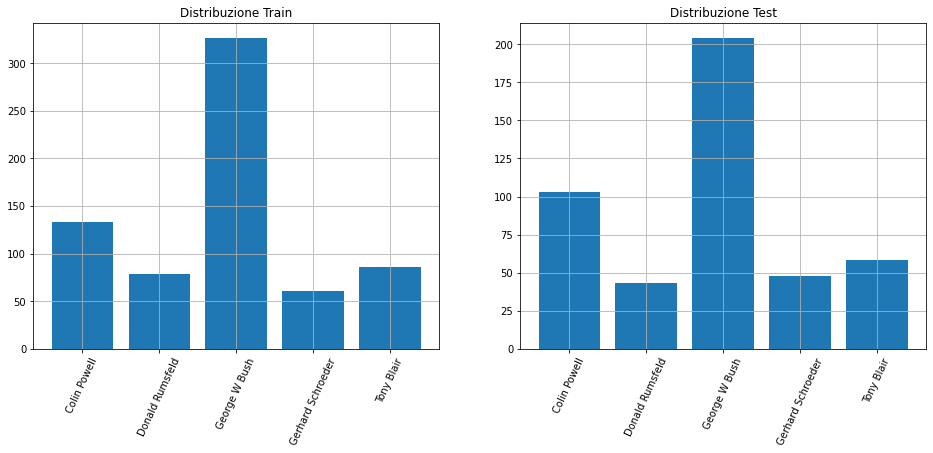

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].set_title('Distribuzione Train')

y_train_df = pd.DataFrame(y_trainval)

axs[0].bar(np.arange(len(face_tnames)), y_train_df[0].value_counts(sort = False))
axs[0].set_xticks(np.arange(len(face_tnames)))
axs[0].set_xticklabels(face_tnames, rotation=65)
axs[0].grid()

axs[1].set_title('Distribuzione Test')
y_test_df = pd.DataFrame(y_test)

axs[1].bar(np.arange(len(face_tnames)), y_test_df[0].value_counts(sort = False))
axs[1].set_xticks(np.arange(len(face_tnames)))
axs[1].set_xticklabels(face_tnames, rotation=65)
axs[1].grid()

plt.show()

## PCA
#### ora processo il dataset utilizzando la PCA: in questo modo posso ridurre la dimensionalità dei dati che, essendo immagini, hanno moltissime features (pari al numero di pixel)

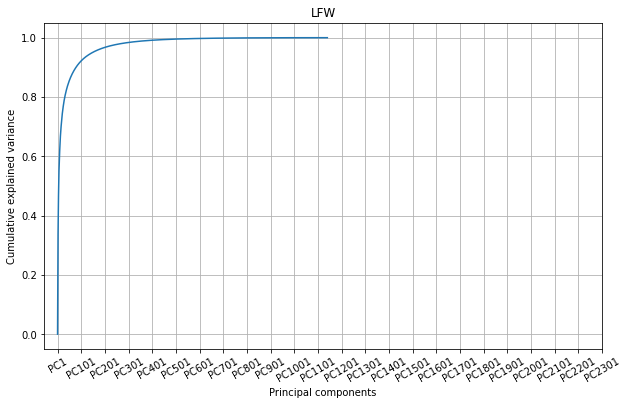

In [19]:

pca_global = PCA()

pca_global.fit(face_data)


expld_variance_global = np.insert(np.cumsum(pca_global.explained_variance_ratio_), 0, 0)

plt.figure(figsize=(10, 6))
plt.plot(expld_variance_global)
plt.title('LFW')
plt.xticks(ticks=np.arange(1, pca_global.n_features_ + 1, 100),
           labels=[f'PC{i}' for i in range(1, pca_global.n_features_ + 1, 100)],
           rotation=30)
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.grid()
plt.show()

Analizzando la varianza cumulativa delle varie componenti principali possiamo tranquillamente ridurre la dimensionalità delle immagini: infatti possiamomantenere olte 80% della varianza spiegata mantenendo solamente 29 componenti principali anche se da questo momento in poi i dati non potranno più essere interpretati come valori delle intensità luminose di pixel che compongono l'immagine

La pca viene calcolata solamente sulla porzione di dati destinata all'addestramento della rete neurale e non quella destinata al test: infatti ha senso solo addestrare il NN con i soli dati che avrebbe a disposizione e non anche con quelli con cui poi verrò utilizzato in futuro. Per questa ragione i dati di Testing subiscono la PCA calcolata però sui dati di Training

In [20]:
pca = PCA(0.8)

pca.fit(X_trainval)

display(pd.DataFrame({'Numero PC': pca.n_components_, 
                      '% Varianza Tot. Spiegata': pca.explained_variance_ratio_.sum()}, 
                     index=['X_trainval']))

X_trainval = pca.transform(X_trainval)

X_test = pca.transform(X_test)

,Numero PC,% Varianza Tot. Spiegata
X_trainval,29,0.803236


### Interpretazione
Posso interpretare una PC come una specifica combinazione lineare di pixel che formano un immagine: ad esempio la prima e la seconda PC calcolata si possono visualizzare così:


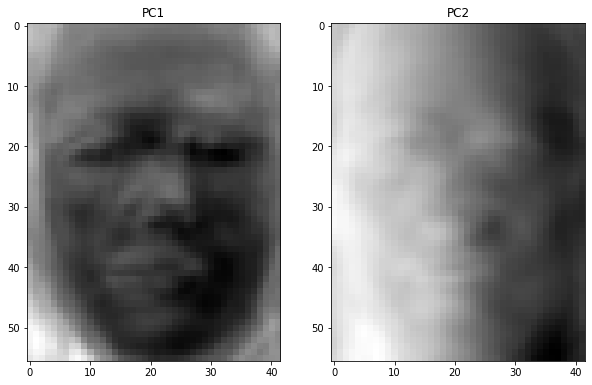

In [21]:
_, height, width = face_images.shape
eigenfaces = [pca.components_[i].reshape((height, width)) for i in [0, 1]]

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].set_title('PC1')
axs[0].imshow(eigenfaces[0], cmap = plt.cm.gray)
axs[1].set_title('PC2')
axs[1].imshow(eigenfaces[1], cmap = plt.cm.gray)
plt.show()

## MLP
Ora inizializzo la rete neurale con i parametri necessari per l'addestrameto

In [22]:
# Inizializzazione iper-parametri MLP
hidden_layer_sizes = [600]*2
activation = 'relu'
patience = 75
max_epochs = 5000
verbose = False
batch_sz = 4

# Inizializzazione MLP
mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, batch_size=batch_sz, max_iter=max_epochs, early_stopping=True, n_iter_no_change=patience, random_state=random_state ,validation_fraction=val_p, solver= 'adam')

mlp_ros = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, batch_size=batch_sz, max_iter=max_epochs, early_stopping=True, n_iter_no_change=patience, random_state=random_state ,validation_fraction=val_p, solver= 'adam')

### Oversampling
Essendo il dataset sbilanciato, ho deciso di applicare una tecnica di Oversampling casuale: in questo i dati delle classi che hanno meno istanze venogono riaggiunti al dataset in modo casuale in modo da pareggiare il numero di campioni presenti nella classe più numerosa;
durante l'analisi manterrò in parallelo i due approcci per vedere qual'è il più efficace per addestrare questo tipo di rete neurale

In [23]:
ros = RandomOverSampler(random_state= random_state)
X_trainval_ros, y_trainval_ros = ros.fit_resample(X_trainval, y_trainval)

Dopo l'OverSampling possiamo visualizzare la nuova distribuzione delle classi all'interno della porzione di dataset usata per l'addestramento

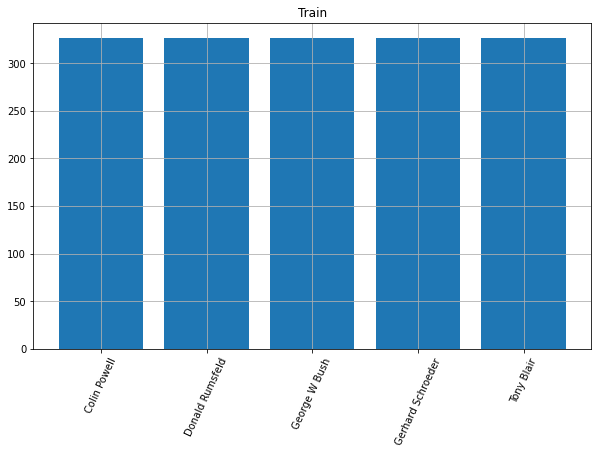

In [24]:
plt.figure(figsize=(10, 6))
plt.title('Train')

y_train_ros_df = pd.DataFrame(y_trainval_ros)

plt.bar(np.arange(len(face_tnames)), y_train_ros_df[0].value_counts(sort = False))
plt.xticks(np.arange(len(face_tnames)), labels = face_tnames, rotation = 65)
plt.grid()
plt.show()

### Risultati:
le classi hanno un pari numero di campioni ora e quindi, anche se molti campioni sono ripetuti senza variazioni, questo dovrebbe portare ad un miglioramento generale dell'accuratezza del N.N.

Ho pensato di applicare l'Oversampling dopo aver applicato la pca perché altrimenti questo avrebbe variato la varianza dei dati e quindi avrebbe alterato la scelta delle componenti principali 

### Addestramento MLP

In [25]:
# Addestramento MLP
mlp.fit(X_trainval, y_trainval)
mlp_ros.fit(X_trainval_ros, y_trainval_ros)

MLPClassifier(batch_size=4, early_stopping=True, hidden_layer_sizes=[600, 600],
              max_iter=5000, n_iter_no_change=75, random_state=20212207,
              validation_fraction=0.25)

A questo punto testiamo il NN per verificare le sue capacità predittive sulla porzione di dati riservata al testing

,Accuracy,Precision,Recall,F1
train. + val.,0.932749,0.935253,0.932749,0.932555
test,0.758772,0.762331,0.758772,0.758636


,Accuracy,Precision,Recall,F1
train. + val.,0.990184,0.990284,0.990184,0.990176
test,0.800439,0.798260,0.800439,0.794673


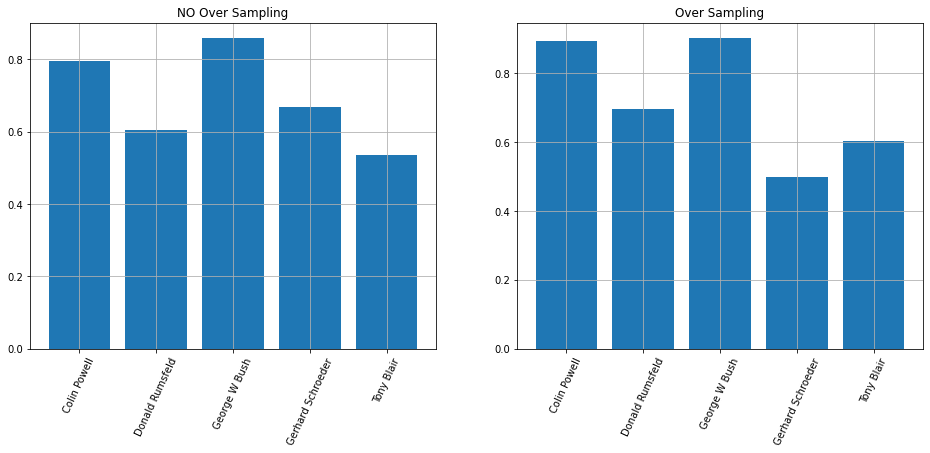

In [26]:
y_pred_trainval = mlp.predict(X_trainval)
y_pred = mlp.predict(X_test)

acc_trainval = mlp.score(X_trainval, y_trainval)
prec_trainval = precision_score(y_trainval, y_pred_trainval, average='weighted')
rec_trainval = recall_score(y_trainval, y_pred_trainval, average='weighted')
f1_trainval = f1_score(y_trainval, y_pred_trainval, average='weighted')

acc = mlp.score(X_test, y_test)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

df_perf = pd.DataFrame({'Accuracy': [acc_trainval, acc], 
                        'Precision': [prec_trainval, prec], 
                        'Recall': [rec_trainval, rec],
                        'F1': [f1_trainval, f1]
                       },
                      index=['train. + val.', 'test'])

cmat = confusion_matrix(y_test, y_pred, labels=mlp.classes_)
cmat_norm_true = confusion_matrix(y_test, y_pred, labels=mlp.classes_, normalize='true')
cmat_norm_pred = confusion_matrix(y_test, y_pred, labels=mlp.classes_, normalize='pred')

df_cmat = pd.DataFrame(cmat, columns=face_tnames, index=face_tnames)
df_cmat_norm_true = pd.DataFrame(cmat_norm_true, columns=face_tnames, index=face_tnames)
df_cmat_norm_pred = pd.DataFrame(cmat_norm_pred, columns=face_tnames, index=face_tnames)

y_pred_trainval_ros = mlp_ros.predict(X_trainval_ros)
y_pred_ros = mlp_ros.predict(X_test)

acc_trainval_ros = mlp_ros.score(X_trainval_ros, y_trainval_ros)
prec_trainval_ros = precision_score(y_trainval_ros, y_pred_trainval_ros, average='weighted')
rec_trainval_ros = recall_score(y_trainval_ros, y_pred_trainval_ros, average='weighted')
f1_trainval_ros = f1_score(y_trainval_ros, y_pred_trainval_ros, average='weighted')

acc_ros = mlp_ros.score(X_test, y_test)
prec_ros = precision_score(y_test, y_pred_ros, average='weighted')
rec_ros = recall_score(y_test, y_pred_ros, average='weighted')
f1_ros = f1_score(y_test, y_pred_ros, average='weighted')

df_perf_ros = pd.DataFrame({'Accuracy': [acc_trainval_ros, acc_ros], 
                        'Precision': [prec_trainval_ros, prec_ros], 
                        'Recall': [rec_trainval_ros, rec_ros],
                        'F1': [f1_trainval_ros, f1_ros]
                       },
                      index=['train. + val.', 'test'])

cmat_ros = confusion_matrix(y_test, y_pred_ros, labels=mlp.classes_)
cmat_norm_true_ros = confusion_matrix(y_test, y_pred_ros, labels=mlp.classes_, normalize='true')
cmat_norm_pred_ros = confusion_matrix(y_test, y_pred_ros, labels=mlp.classes_, normalize='pred')

display(df_perf)
display(df_perf_ros)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].set_title('NO Over Sampling')

axs[0].bar(np.arange(len(face_tnames)), [cmat_norm_true[t][t] for t in range(len(face_tnames))])
axs[0].set_xticks(np.arange(len(face_tnames)))
axs[0].set_xticklabels(face_tnames, rotation=65)
axs[0].grid()

axs[1].set_title('Over Sampling')

axs[1].bar(np.arange(len(face_tnames)), [cmat_norm_true_ros[t][t] for t in range(len(face_tnames))])
axs[1].set_xticks(np.arange(len(face_tnames)))
axs[1].set_xticklabels(face_tnames, rotation=65)
axs[1].grid()
#display(df_cmat)
#display(df_cmat_norm_true)
#display(df_cmat_norm_pred)

### Risultati
Possiamo notare come il NN addestrato senza oversampling abbia una prestazione peggiore in quasi tutti gli aspetti; solamente nel caso di Schroeder si è verificato un peggiornamento della capacità predittiva, in tutti gli altri casi invece (soprattutto per le classi che originariamente avevano meno campioni) si è verificato un miglioramento.
Per ulteriormente verificare il funzionamento dell'Oversampling ho creato due Grafici che mostrano il numero di "Guess" errati che ogni classe ha ricevuto:

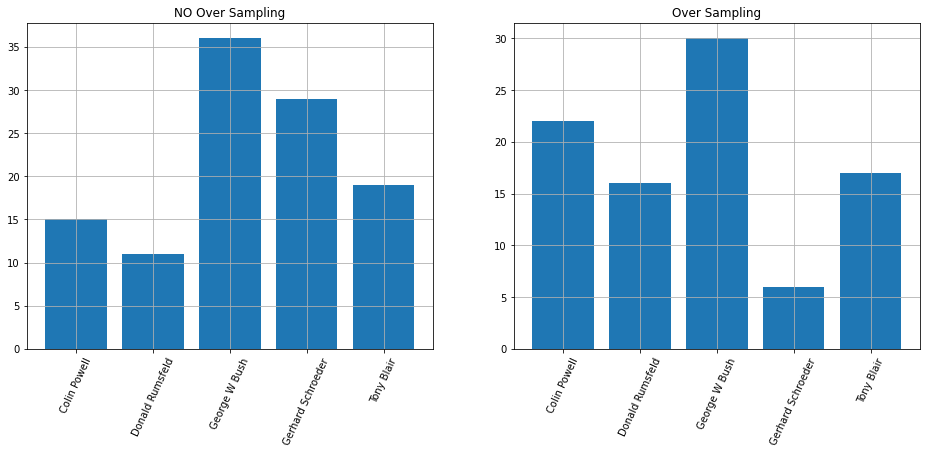

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].set_title('NO Over Sampling')

axs[0].bar(np.arange(len(face_tnames)), [np.sum(cmat[:,t]) -cmat[t][t] for t in range(len(face_tnames))])
axs[0].set_xticks(np.arange(len(face_tnames)))
axs[0].set_xticklabels(face_tnames, rotation=65)
axs[0].grid()

axs[1].set_title('Over Sampling')

axs[1].bar(np.arange(len(face_tnames)), [np.sum(cmat_ros[:,t]) -cmat_ros[t][t] for t in range(len(face_tnames))])
axs[1].set_xticks(np.arange(len(face_tnames)))
axs[1].set_xticklabels(face_tnames, rotation=65)
axs[1].grid()

plt.show()

### Risultati
Si può chiaramente notare che il numero di errore si distribuisce più equamente nelle classi e non interessa più così maggiormente le classi i cui campioni compaiono i modo molto più significativo